>>> Paso 0: Configuración lista. Periodos mensuales simulados: 180
>>> Paso 1: Datos simulados.
            pi       ds     ygap        i
count  179.000  179.000  179.000  179.000
mean     0.113    0.002   -0.169   -0.138
std      0.234    0.015    0.565    0.540
min     -0.562   -0.023   -1.773   -1.561
25%     -0.064   -0.007   -0.563   -0.450
50%      0.087    0.001   -0.188   -0.171
75%      0.283    0.008    0.238    0.191
max      0.617    0.078    1.640    1.166


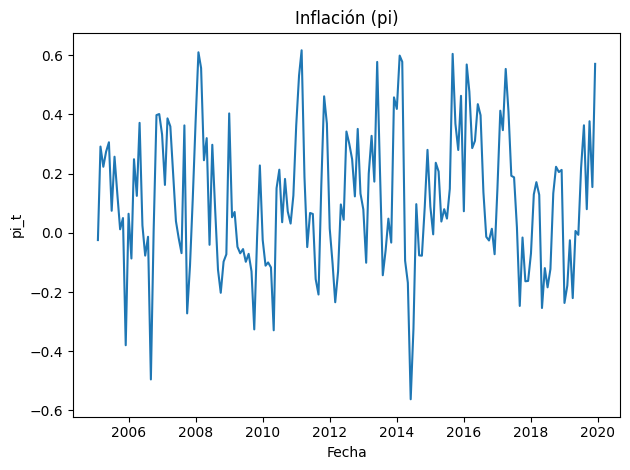

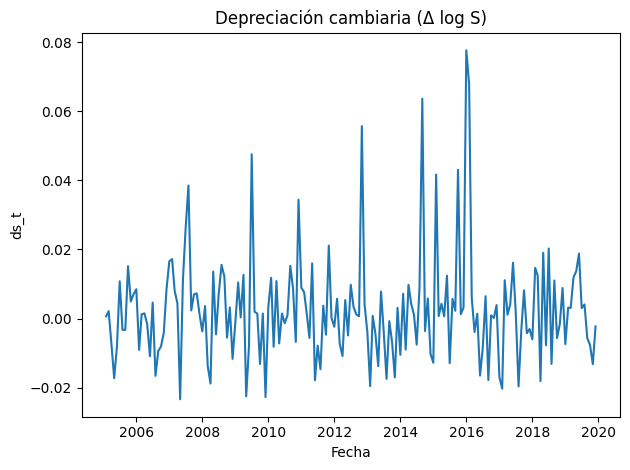

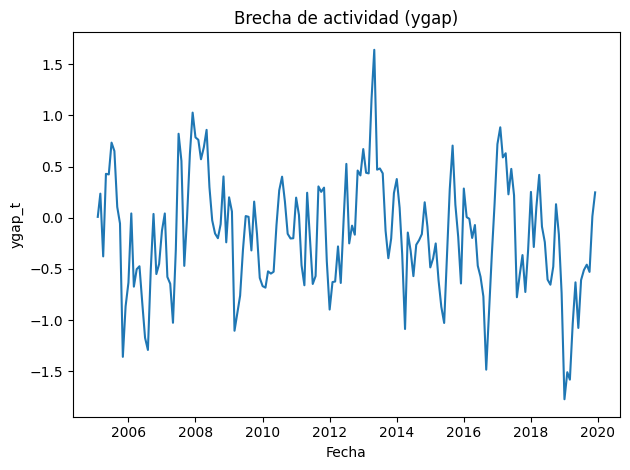

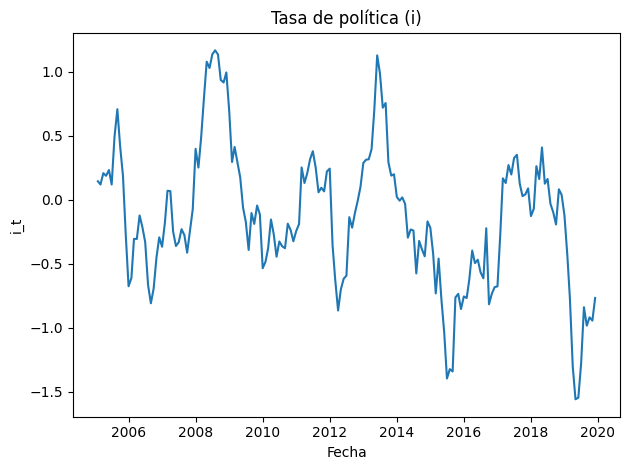

>>> Paso 2: Gráficas básicas mostradas.

>>> Paso 3: Benchmark lineal ARX(1) (s.e. robustos)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     33.52
Date:                Tue, 30 Sep 2025   Prob (F-statistic):           1.01e-20
Time:                        14:21:00   Log-Likelihood:                 58.071
No. Observations:                 179   AIC:                            -106.1
Df Residuals:                     174   BIC:                            -90.21
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------

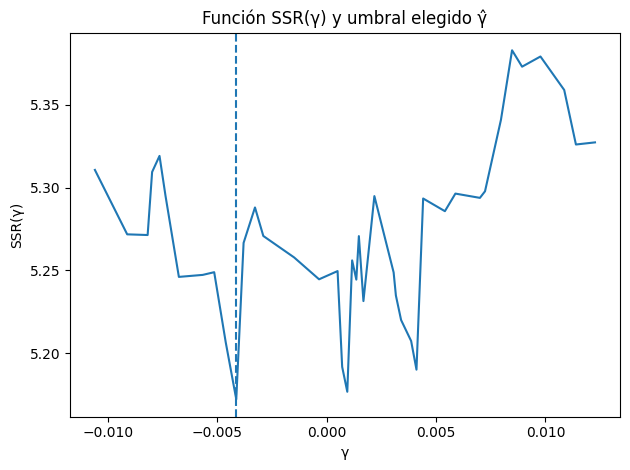


Coeficientes por régimen (s.e. HC1):

Regimen 1 (Q<=γ̂)
           coef  se(HC1)
const    0.150    0.053
pi_l1    0.185    0.105
ds_l1    1.563    4.364
ygap_l1  0.223    0.042
i_l1    -0.108    0.055

Regimen 2 (Q>γ̂)
           coef  se(HC1)
const    0.041    0.023
pi_l1    0.514    0.073
ds_l1    1.004    1.214
ygap_l1  0.153    0.033
i_l1    -0.126    0.028

>>> Paso 6: AIC/BIC (comparación simple)
AIC(lineal) = -614.12 | BIC(lineal) = -598.19
AIC(TAR@γ̂)  = -614.39 | BIC(TAR@γ̂)  = -582.52

>>> Paso 7: sup-Wald (esqueleto)
sup-Wald = 9.982 (en γ = -0.0041). La distribución nula no es estándar.


c:\Users\paulo.ramos\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
C:\Users\paulo.ramos\AppData\Local\Temp\ipykernel_48068\4037591898.py:221: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  F = float(w.fvalue)


p-valor bootstrap (wild, B=99): 0.490  -> si < 0.10, evidencia de umbral.


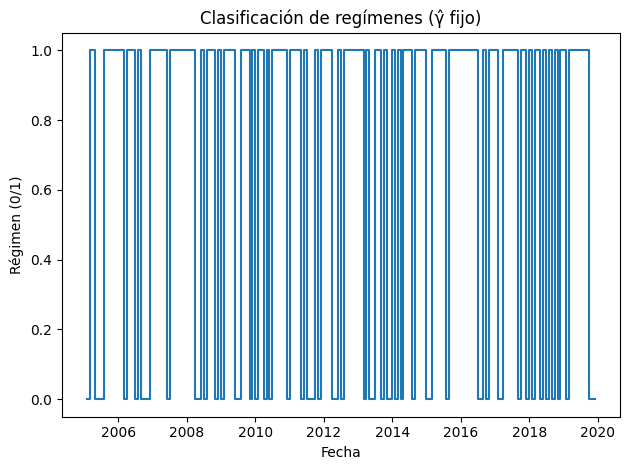


>>> Paso 8: Interpretación/resumen
- Umbral estimado γ̂ ≈ -0.0041. Fracción en régimen 2 (depreciación alta): 67.60%.
- Compare el coeficiente de ds_l1 por régimen (pass-through cambiario).
  Régimen 1 (Q<=γ̂): {'coef': 1.562549871494965, 'se(HC1)': 4.363799555361418}
  Régimen 2 (Q> γ̂): {'coef': 1.0042143900804257, 'se(HC1)': 1.213926081318604}
- Persistencia (pi_l1) por régimen:
  Régimen 1: {'coef': 0.18466506223272047, 'se(HC1)': 0.1047319882443351}
  Régimen 2: {'coef': 0.514311838180117, 'se(HC1)': 0.07336621430908913}
- Prueba sup-Wald: p-valor ≈ 0.490.
- Recomendación docente: contrastar AIC/BIC y validar con pronósticos out-of-sample;
  además, revisar diagnóstico de residuos (autocorrelación/ARCH) por régimen si el tiempo lo permite.


In [1]:
# =============================================================================
# Demostración TAR paso a paso (en español) con datos sintéticos tipo Perú
# =============================================================================
# Objetivo docente:
# 1) Simular series mensuales: inflación (pi), depreciación cambiaria (ds),
#    brecha de actividad (ygap) y tasa de política (i).
# 2) Graficar y describir.
# 3) Estimar un modelo ARX lineal como benchmark.
# 4) Especificar un TAR simple (dos regímenes) con umbral en ds_{t-1}.
# 5) Elegir el umbral por grid-search con "trimming".
# 6) Estimar parámetros por régimen y comparar con el modelo lineal.
# 7) Probar no linealidad con un sup-Wald + bootstrap salvaje (pedagógico).
# 8) Comentar e interpretar resultados.
#
# Notas de estilo (exigencias de la clase):
# - Solo matplotlib, una figura por gráfico, sin colores específicos.
# - Comentarios y 'prints' en español.
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------------------------------------------------------
# 0) Configuración y semilla
# -----------------------------------------------------------------------------
rng = np.random.default_rng(123)
T = 180  # ~15 años mensuales
fechas = pd.period_range('2005-01', periods=T, freq='M').to_timestamp()

print(">>> Paso 0: Configuración lista. Periodos mensuales simulados:", T)

# -----------------------------------------------------------------------------
# 1) Simulación de datos sintéticos "tipo Perú"
# -----------------------------------------------------------------------------
# Shocks estructurales
eps_pi = rng.normal(0, 0.20, T)   # shock a inflación
eps_ds = rng.normal(0, 0.01, T)   # ruido en depreciación
eps_y  = rng.normal(0, 0.40, T)   # ruido en brecha de actividad
eps_i  = rng.normal(0, 0.15, T)   # ruido en tasa de política

# Brecha de actividad: AR(1) persistente
ygap = np.zeros(T)
for t in range(1, T):
    ygap[t] = 0.7*ygap[t-1] + eps_y[t]

# Tasa de política: inercia + reacción a actividad e inflación
i_rate = np.zeros(T)
for t in range(1, T):
    i_rate[t] = 0.85*i_rate[t-1] + 0.2*ygap[t-1] + 0.15*eps_pi[t-1] + eps_i[t]

# Depreciación cambiaria mensual (Δ log S) con choques ocasionales "grandes"
ds = eps_ds.copy()
grandes = rng.choice(np.arange(2, T), size=10, replace=False)
ds[grandes] += rng.normal(0.04, 0.015, size=grandes.size)  # 4-5% mensual aprox.

# Inflación como TAR "verdadero" (solo para simular) con umbral en ds_{t-1}
# pi_t = mu_j + phi_j*pi_{t-1} + b_j*ds_{t-1} + c*ygap_{t-1} + d*i_{t-1} + error
gamma_true = 0.02  # 2%
mu1, phi1, b1 = 0.05, 0.40, 0.15  # régimen 1 (depreciación baja)
mu2, phi2, b2 = 0.08, 0.65, 0.40  # régimen 2 (depreciación alta)
c, d = 0.10, -0.05                 # controles (invariantes por régimen)

pi = np.zeros(T)
for t in range(1, T):
    reg2 = ds[t-1] > gamma_true
    mu  = mu2 if reg2 else mu1
    phi = phi2 if reg2 else phi1
    b   = b2  if reg2 else b1
    pi[t] = mu + phi*pi[t-1] + b*ds[t-1] + c*ygap[t-1] + d*i_rate[t-1] + eps_pi[t]

# DataFrame principal
df = pd.DataFrame({
    'pi': pi,
    'ds': ds,
    'ygap': ygap,
    'i': i_rate,
}, index=fechas)

# Rezgagos para ARX(1)
df['pi_l1'] = df['pi'].shift(1)
df['ds_l1'] = df['ds'].shift(1)
df['ygap_l1'] = df['ygap'].shift(1)
df['i_l1']   = df['i'].shift(1)
df = df.dropna().copy()

print(">>> Paso 1: Datos simulados.")
print(df[['pi','ds','ygap','i']].describe().round(3))

# -----------------------------------------------------------------------------
# 2) Gráficas básicas (una figura por gráfico)
# -----------------------------------------------------------------------------
plt.figure()
plt.plot(df.index, df['pi'])
plt.title('Inflación (pi)')
plt.xlabel('Fecha'); plt.ylabel('pi_t')
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(df.index, df['ds'])
plt.title('Depreciación cambiaria (Δ log S)')
plt.xlabel('Fecha'); plt.ylabel('ds_t')
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(df.index, df['ygap'])
plt.title('Brecha de actividad (ygap)')
plt.xlabel('Fecha'); plt.ylabel('ygap_t')
plt.tight_layout(); plt.show()

plt.figure()
plt.plot(df.index, df['i'])
plt.title('Tasa de política (i)')
plt.xlabel('Fecha'); plt.ylabel('i_t')
plt.tight_layout(); plt.show()

print(">>> Paso 2: Gráficas básicas mostradas.")

# -----------------------------------------------------------------------------
# 3) Benchmark: ARX(1) lineal con errores estándar robustos (HC1)
# -----------------------------------------------------------------------------
Y = df['pi'].values
X = sm.add_constant(df[['pi_l1','ds_l1','ygap_l1','i_l1']].values)
lin_mod = sm.OLS(Y, X).fit(cov_type='HC1')

print("\n>>> Paso 3: Benchmark lineal ARX(1) (s.e. robustos)")
print(lin_mod.summary())

# -----------------------------------------------------------------------------
# 4) Especificación TAR y 5) Búsqueda de umbral por grilla con trimming
# -----------------------------------------------------------------------------
# Variable umbral: Q_t = ds_{t-1}
Q = df['ds_l1'].values

# Grid "trimeado": percentiles 15% a 85%, 41 puntos (ajustar si se desea)
grid = np.quantile(Q, np.linspace(0.15, 0.85, 41))

def ajustar_tar_en_gamma(gamma, y, X, Q, min_frac=0.10):
    """
    Estima dos regresiones OLS (con s.e. robustos para reporte) condicionadas
    al corte Q <= gamma y Q > gamma. Devuelve SSR total y los resultados.
    """
    I1 = Q <= gamma
    I2 = Q > gamma
    # Exigir tamaño mínimo por régimen (p.ej. 10%)
    if I1.mean() < min_frac or I2.mean() < min_frac:
        return np.inf, None, None, I1, I2
    res1 = sm.OLS(y[I1], X[I1]).fit(cov_type='HC1')
    res2 = sm.OLS(y[I2], X[I2]).fit(cov_type='HC1')
    ssr = np.sum(res1.resid**2) + np.sum(res2.resid**2)
    return ssr, res1, res2, I1, I2

ssr_list, fits = [], []
for g in grid:
    ssr, r1, r2, I1, I2 = ajustar_tar_en_gamma(g, Y, X, Q)
    ssr_list.append(ssr)
    fits.append((r1, r2, I1, I2))

best_idx = int(np.nanargmin(ssr_list))
gamma_hat = grid[best_idx]
res1_hat, res2_hat, I1_hat, I2_hat = fits[best_idx]

print("\n>>> Paso 4-5: Búsqueda de umbral (grid-search)")
print(f"gamma_hat = {gamma_hat:.4f}")
print(f"Obs por régimen: Reg1(Q<=γ): {I1_hat.sum()} | Reg2(Q>γ): {I2_hat.sum()}")
print(f"SSR(lineal): {np.sum(lin_mod.resid**2):.4f} | SSR(TAR@γ̂): {np.min(ssr_list):.4f}")

# Gráfico docente: SSR(γ) vs γ
plt.figure()
plt.plot(grid, ssr_list)
plt.axvline(gamma_hat, linestyle='--')
plt.title('Función SSR(γ) y umbral elegido γ̂')
plt.xlabel('γ'); plt.ylabel('SSR(γ)')
plt.tight_layout(); plt.show()

# Reporte de coeficientes por régimen (con s.e. robustos)
nombres = ['const','pi_l1','ds_l1','ygap_l1','i_l1']
tabla_reg1 = pd.DataFrame({'coef': res1_hat.params, 'se(HC1)': res1_hat.bse}, index=nombres)
tabla_reg2 = pd.DataFrame({'coef': res2_hat.params, 'se(HC1)': res2_hat.bse}, index=nombres)
print("\nCoeficientes por régimen (s.e. HC1):\n\nRegimen 1 (Q<=γ̂)\n", tabla_reg1.round(3))
print("\nRegimen 2 (Q>γ̂)\n", tabla_reg2.round(3))

# -----------------------------------------------------------------------------
# 6) Comparación AIC/BIC lineal vs TAR (condicional en γ̂)
# -----------------------------------------------------------------------------
n = len(Y)
k = X.shape[1]              # nº de parámetros por régimen (incluye constante)
k_tot = 2*k                 # dos regímenes con parámetros distintos
sigma2_lin = np.sum(lin_mod.resid**2) / n
sigma2_tar = np.min(ssr_list) / n

AIC_lin = n*np.log(sigma2_lin) + 2*k
BIC_lin = n*np.log(sigma2_lin) + k*np.log(n)
AIC_tar = n*np.log(sigma2_tar) + 2*k_tot
BIC_tar = n*np.log(sigma2_tar) + k_tot*np.log(n)

print("\n>>> Paso 6: AIC/BIC (comparación simple)")
print(f"AIC(lineal) = {AIC_lin:.2f} | BIC(lineal) = {BIC_lin:.2f}")
print(f"AIC(TAR@γ̂)  = {AIC_tar:.2f} | BIC(TAR@γ̂)  = {BIC_tar:.2f}")

# -----------------------------------------------------------------------------
# 7) Prueba pedagógica de no linealidad: sup-Wald + bootstrap salvaje
# -----------------------------------------------------------------------------
def wald_en_gamma(gamma, y, X, Q, min_frac=0.10):
    """
    Wald para H0: parámetros iguales en ambos regímenes.
    Armamos y = [X*I1 | X*I2] * [b1; b2] + e, y testeamos b1 == b2.
    Devolvemos estadístico tipo Wald (aprox): W = F * k.
    """
    I1 = (Q <= gamma).astype(float)
    I2 = 1.0 - I1
    if I1.mean() < min_frac or I2.mean() < min_frac:
        return np.nan
    Xs = np.column_stack([X * I1[:,None], X * I2[:,None]])
    res = sm.OLS(y, Xs).fit()
    k = X.shape[1]
    R = np.hstack([np.eye(k), -np.eye(k)])
    r = np.zeros(k)
    w = res.wald_test((R, r), use_f=True)  # F con k restricciones
    F = float(w.fvalue)
    W = F * k
    return W

wald_vals = []
validos = []
for g in grid:
    I1 = Q <= g; I2 = Q > g
    ok = (I1.mean() >= 0.10) and (I2.mean() >= 0.10)
    validos.append(ok)
    w = wald_en_gamma(g, Y, X, Q) if ok else np.nan
    wald_vals.append(w)

wald_arr = np.array(wald_vals)
sup_wald = np.nanmax(wald_arr)
g_sup = grid[np.nanargmax(wald_arr)]
print("\n>>> Paso 7: sup-Wald (esqueleto)")
print(f"sup-Wald = {sup_wald:.3f} (en γ = {g_sup:.4f}). La distribución nula no es estándar.")

# Bootstrap salvaje (bajo H0 lineal): y* = X b̂ + resid * eta, con eta en {-1,+1}
B = 99  # para clase; aumentar offline si se desea
ajuste_lin = lin_mod.fittedvalues
resid_lin = lin_mod.resid
sup_star = np.zeros(B)
for b in range(B):
    eta = np.where(rng.random(len(resid_lin)) < 0.5, -1.0, 1.0)
    y_star = ajuste_lin + resid_lin * eta
    wstars = []
    for g, ok in zip(grid, validos):
        if not ok:
            wstars.append(np.nan); continue
        wstars.append(wald_en_gamma(g, y_star, X, Q))
    sup_star[b] = np.nanmax(wstars)
pval = (np.sum(sup_star >= sup_wald) + 1) / (B + 1)

print(f"p-valor bootstrap (wild, B={B}): {pval:.3f}  -> si < 0.10, evidencia de umbral.")

# -----------------------------------------------------------------------------
# 8) Clasificación de regímenes y lectura docente
# -----------------------------------------------------------------------------
regime = (Q > gamma_hat).astype(int)  # 0 = régimen 1, 1 = régimen 2

plt.figure()
plt.step(df.index, regime, where='post')
plt.title('Clasificación de regímenes (γ̂ fijo)')
plt.xlabel('Fecha'); plt.ylabel('Régimen (0/1)')
plt.tight_layout(); plt.show()

print("\n>>> Paso 8: Interpretación/resumen")
print(f"- Umbral estimado γ̂ ≈ {gamma_hat:.4f}. Fracción en régimen 2 (depreciación alta): {regime.mean():.2%}.")
print("- Compare el coeficiente de ds_l1 por régimen (pass-through cambiario).")
print("  Régimen 1 (Q<=γ̂):", (tabla_reg1.loc['ds_l1']).to_dict())
print("  Régimen 2 (Q> γ̂):", (tabla_reg2.loc['ds_l1']).to_dict())
print("- Persistencia (pi_l1) por régimen:")
print("  Régimen 1:", (tabla_reg1.loc['pi_l1']).to_dict())
print("  Régimen 2:", (tabla_reg2.loc['pi_l1']).to_dict())
print(f"- Prueba sup-Wald: p-valor ≈ {pval:.3f}.")
print("- Recomendación docente: contrastar AIC/BIC y validar con pronósticos out-of-sample;")
print("  además, revisar diagnóstico de residuos (autocorrelación/ARCH) por régimen si el tiempo lo permite.")
